# Weather Analysis by Latitude

## Overview

This Python script will visualize the weather of 500+ unique cities across the world in random locations. [Citipy](https://pypi.python.org/pypi/citipy) a simple city-finding python package will be used to find randomly located cities, and the [OpenWeatherMap API](https://openweathermap.org/api), will return current weather statistics for those cities.

A series of scatter plots will be used to showcase the following relationships:

* Temperature (F) vs. Latitude.
* Humidity (%) vs. Latitude.
* Cloudiness (%) vs. Latitude.
* Wind Speed (mph) vs. Latitude.

Specificially, this script will:

* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
* Perform a weather check on each of the cities using a series of successive API calls. 
* Include a print log of each city as it's being processed with the city number, city name, and requested URL.
* Save both a CSV of all data retrieved and png images for each scatter plot.

In [1]:
# Import dependencies.
from citipy import citipy
import numpy as np
import pandas as pd
import random
import requests as req
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Import Open Weather Map API keys.
from openWeatherMapApiKeys import apiKey


## Improving The Smple of Cities

Finding a city at random latitudes and longitudes with Citipy can be problematic as randomly selected remote locations, such as in the middle of the Pacific Ocean or in Antarctica may yield a city thousands of miles away in any direction. This is a problem for extremely northern or southern latitudes, or longitudes in the Pacific Ocean: random points in these areas inflate the number of cities selected in extreme northern or southern areas, or around the Pacific Rim.

To solve this, the range of latitudes is restricted to between 55th parallel south (running through Patagonia, Argentina) and 65th parallel north (running through southern Greenland and northern Canada). Longitudes are restricted to between 140th meridian west (which removes most of Alaska from the sample) and 160 meridian east (which leaves points west of Australia out). This yields a more uniform distribution of points that resolve to a city in Citipy, particularly by latitude.

In [2]:
# Declare variables describing the scope of lat/lng search for cities.
latDim = {'min': -55, 'max': 65}
lngDim = {'min': -140, 'max': 180}

# Create arrays containing increments of lat and long.
latVals = np.arange(latDim['min'], latDim['max'], 0.1)
lngVals = np.arange(lngDim['min'], lngDim['max'], 0.1)

In [5]:
# Create an empty data frame that will contain details of our randomly selected cities.
colNames = ('cityName', 'countryCode', 'randLat', 'randLng', 'uniqueName', 'Latitude', 'Longitude','Temperature',
            'Humidity','Cloudiness','WindSpeed')
cities = pd.DataFrame(columns = colNames)

In [8]:
# Query Citipy for random lat long values until we collect our sample, and append weather
# data via API call.

# Set the sample size (this will return exactly as many records as the sample size).
sampleSize = 500

baseUrl = 'http://api.openweathermap.org/data/2.5/weather?q='
units = 'imperial'

while len(cities) <= sampleSize:
    # Choose a random point within our lat-lng domain.
    randLat = random.choice(latVals)
    randLng = random.choice(lngVals)
    # Call citipy's nearest_city() method to get a city object.
    city = citipy.nearest_city(randLat, randLng)
    cityName = city.city_name
    countryCode = city.country_code
    # Check if the combination of city name and country code from citipy is already present in our data frame
    # This is the best that can be done with the nearest_city() method.
    if cityName + countryCode in cities.uniqueName.tolist():
        pass
    else:
        url = baseUrl + cityName + ',' + countryCode + '&units=' + units + '&APPID=' + apiKey
        weather_response = req.get(url)
        weather_json = weather_response.json()
        print('Status code: %s DF Length is now: %s' % (str(weather_json["cod"]), str(len(cities))))
        if weather_json["cod"] == 200:
            print('City %s: %s loaded with status %s: %s' % (weather_json['id'], weather_json['name'], weather_json["cod"], url))
            Latitude = weather_json["coord"]["lat"]
            Longitude = weather_json["coord"]["lon"]
            Temperature = weather_json["main"]["temp"]
            Humidity = weather_json["main"]["humidity"]
            Cloudiness = weather_json["clouds"]["all"]
            WindSpeed = weather_json["wind"]["speed"]
            cities.loc[len(cities)+1] = [weather_json['name'], countryCode, randLat, randLng, cityName+countryCode, Latitude, Longitude, Temperature, Humidity, Cloudiness, WindSpeed]
#             cities = concat(cities, DataFrame([{'cityName': cityName, 'countryCode' : countryCode, 'randLat' : randLat,'randLng' : randLng, 'uniqueName' : cityName, 'Latitude' : Latitude, 'Longitude' : Longitude,'Temperature' : Temperature, 'Humidity' : Humidity,'Cloudiness' : Cloudiness,'WindSpeed' : WindSpeed}])
        else:
            pass


Status code: 200 DF Length is now: 0
City 4030556: Rikitea loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=rikitea,pf&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 200 DF Length is now: 1
City 5991056: Kenora loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=kenora,ca&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 200 DF Length is now: 2
City 792470: Boljevac loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=boljevac,rs&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 200 DF Length is now: 3
City 1515029: Ulaangom loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=ulaangom,mn&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 200 DF Length is now: 4
City 2167426: Emerald loaded with status 200: http://api.openweathermap.org/data/2.5/weather?q=emerald,au&units=imperial&APPID=244a987a274dfd51f4820c3f46a53b02
Status code: 2

In [10]:
print(cities.head())

   cityName countryCode  randLat  randLng  uniqueName  Latitude  Longitude  \
1   Rikitea          pf    -19.4   -136.2   rikiteapf    -23.12    -134.97   
2    Kenora          ca     53.7    -93.9    kenoraca     49.82     -94.43   
3  Boljevac          rs     43.8     22.0  boljevacrs     43.83      21.95   
4  Ulaangom          mn     49.4     92.2  ulaangommn     49.98      92.07   
5   Emerald          au    -23.8    146.6   emeraldau    -23.53     148.17   

   Temperature  Humidity  Cloudiness  WindSpeed  
1        70.21     100.0        48.0       8.52  
2        53.78      81.0        40.0       4.70  
3        48.20      81.0         0.0       2.24  
4        57.52      40.0         0.0       2.71  
5        82.90      21.0         0.0      10.20  


In [11]:
# The total sample size.
len(cities)

501

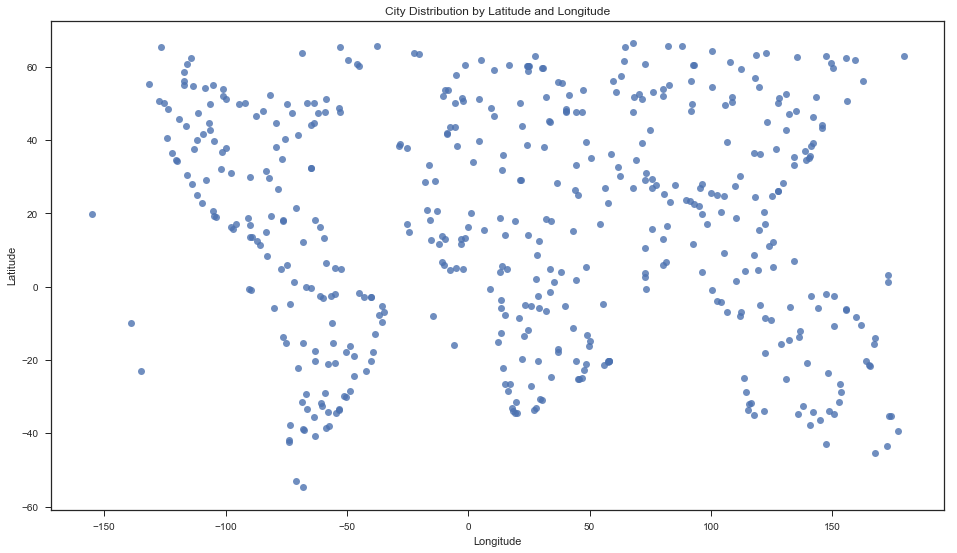

In [12]:
# This is a simple plot of latitude and longitude: it confirms that the sample is sufficiently random across
# the "map" of the world that it shows.
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
p = sns.regplot(x="Longitude", y="Latitude", data=cities, fit_reg=False).set_title('City Distribution by Latitude and Longitude')
plt.show()

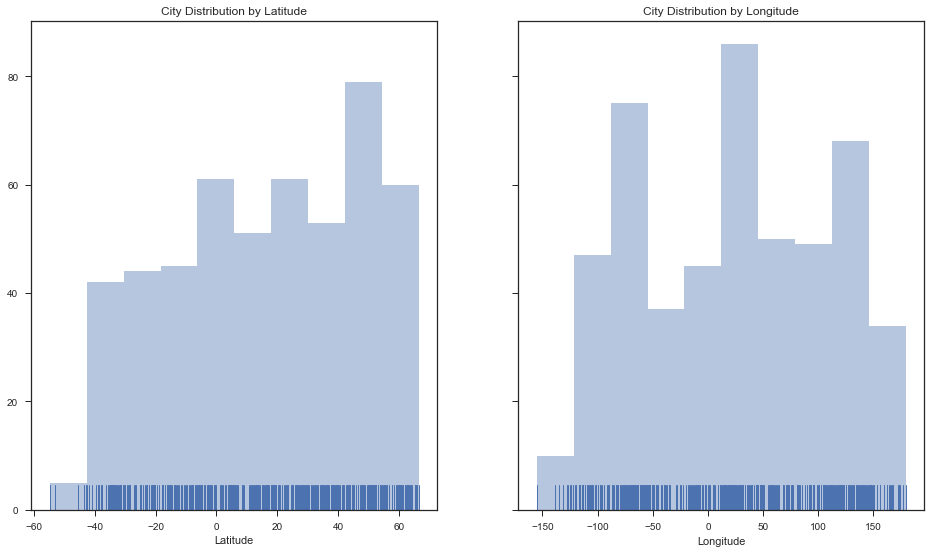

In [13]:
# Show the distribution of cities by latitude and longitude
sns.set_style('ticks')
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(16, 9)
sns.distplot(cities['Latitude'], bins=10, kde=False, rug=True, ax=axs[0]).set_title('City Distribution by Latitude')
sns.distplot(cities['Longitude'], bins=10, kde=False, rug=True, ax=axs[1]).set_title('City Distribution by Longitude')
plt.gcf()

In [15]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
p = sns.regplot(x="Latitude", y="Temperature", data=sorted, fit_reg=False).set_title('Temperature (F) by Latitude')
plt.show()

TypeError: 'builtin_function_or_method' object is not subscriptable

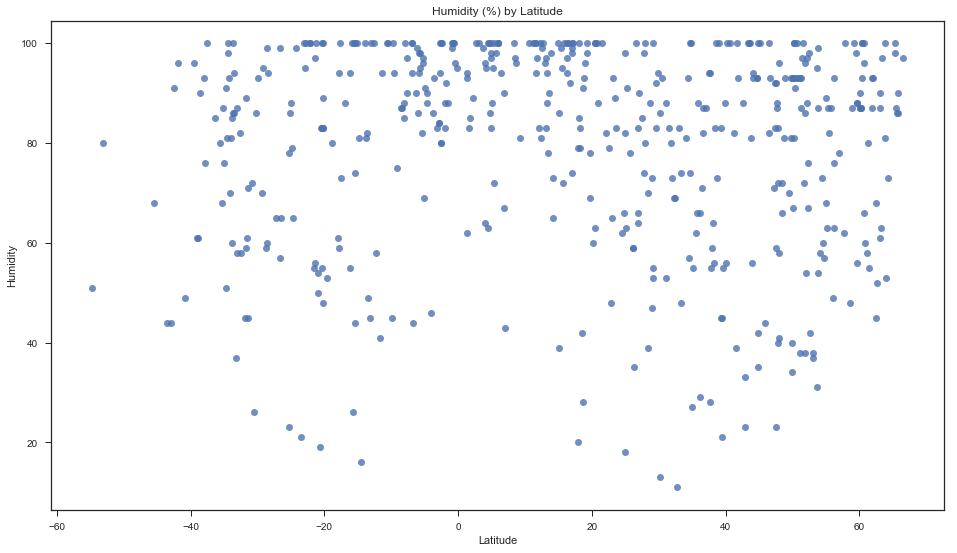

In [20]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
p = sns.regplot(x="Latitude", y="Humidity", data=cities, fit_reg=False).set_title('Humidity (%) by Latitude')
plt.show()

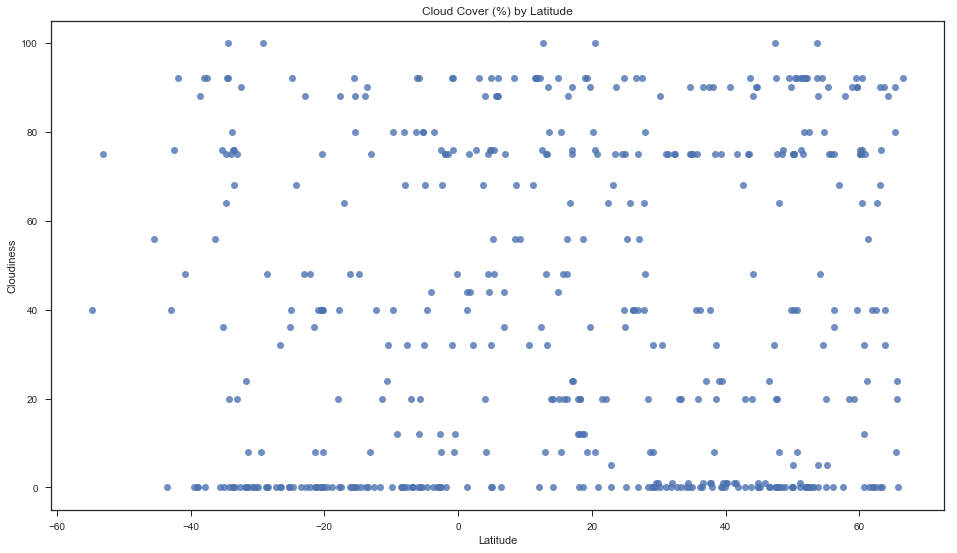

In [19]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
p = sns.regplot(x="Latitude", y="Cloudiness", data=cities, fit_reg=False).set_title('Cloud Cover (%) by Latitude')
plt.show()